In [ ]:
pip install transformers datasets torch gradio

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

from datasets import load_dataset

# Load the Yelp Polarity dataset
dataset = load_dataset('yelp_polarity')


# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_train = dataset['train'].map(tokenize_function, batched=True, num_proc=4)
tokenized_test = dataset['test'].map(tokenize_function, batched=True, num_proc=4)


from transformers import Trainer, TrainingArguments

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch"
)


# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train.select(range(1000)),  # Use a subset for faster training
    eval_dataset=tokenized_test.select(range(500))      # Use a subset for evaluation
)


# Fine-tune the model
trainer.train()

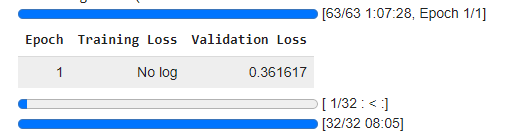

In [ ]:
# Evaluate the model
trainer.evaluate()
# Save the model for future use
model.save_pretrained('./fine_tuned_yelp_model')
tokenizer.save_pretrained('./fine_tuned_yelp_model')

import torch

# Function to perform sentiment prediction using the fine-tuned model
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).item()

    if predictions == 1:
        return "Positive"
    else:
        return "Negative"
    
    
import gradio as gr

# Gradio interface
interface = gr.Interface(fn=predict_sentiment, inputs="text", outputs="text",
                         title="Sentiment Analysis with DistilBERT",
                         description="Enter a review and get a sentiment (positive or negative).")

# Launch the Gradio app
interface.launch()




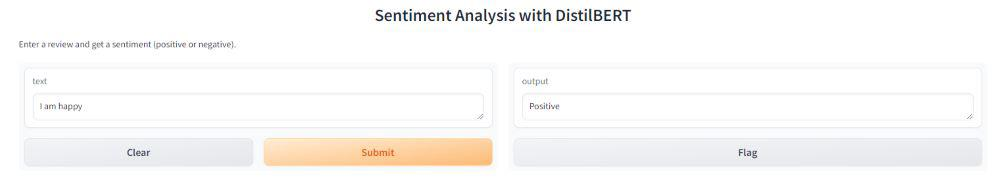